# Github PR Analysis

**Merge-timeline vs. (Lines of Code | Files Changed)**

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following issue metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined

In [1]:
import psycopg2
import numpy as np
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = (15, 5)
import warnings
warnings.filterwarnings('ignore')

with open("../config_temp.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['augur']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[840]


# Files and Lines of Code changed per PR

How does a project handle contributions? In the open source model, changes to a code base are suggested in the form of Pull Requests which are composed of one or more commits made by one or more authors. They become a part of one or more branches of the project when they are 'merged,' and until this time they remain 'open.' In some cases, the suggested changes can be discarded for any number of reasons and in this situation the pull request is considered 'closed.' 

We would like to analyze the PR time-to-merge and PR time-to-close behavior of a project and try to make some generalizations about this behavior. Successful projects may enforce some constraints that, if followed, dramatically increase the probability of a PR being 'merged' rather than 'closed.' 

(A PR being 'closed' does not necessarily mean that the suggested changes were discarded. They could have been broken up into separate PR's and incorporated later. However, this distinction is important to analyze because those PR's that were 'closed' could represent those PR's that don't fit the standards of the project and are important to understand.)

We will begin by visualizing this information in the hope of extracting some useful visual heuristics about these categories of PR. From there, we will go into Survival Analysis, hoping to observe trends in the project including probablistic merge behavior (e.g. there is an 80% chance that a PR of 'x' size will be merged in 'y' time).

**Below:**

Get all of the Pull Requests associated with a specified repository. For each PR also get information about the number of lines changed per file in the PR.

In [4]:
df_pr_files = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
					pr.pull_request_id AS pr_id,
                    prf.pr_file_id as file_id,
                    prf.pr_file_additions as additions,
                    prf.pr_file_deletions as deletions,
                    prf.pr_file_additions + prf.pr_file_deletions as total_changes,
                    pr.pr_created_at as created,
                    pr.pr_merged_at as merged,
                    pr.pr_closed_at as closed
                    
                FROM
                	repo r,
                    pull_requests pr,
                    pull_request_files prf

                WHERE
                	r.repo_id = pr.repo_id AND
                    r.repo_id = \'{repo_id}\' AND
                    prf.pull_request_id = pr.pull_request_id
                ORDER BY
                    pr_id
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr_files = pd.concat([df_pr_files, df_current_repo])

df_pr_files = df_pr_files.reset_index()
df_pr_files.drop("index", axis=1, inplace=True)
        
df_pr_files.head(5)

,pr_id,file_id,additions,deletions,total_changes,created,merged,closed
0,293071,1123096,86,3,89,2017-01-23 18:50:08,2017-01-23 20:49:42,2017-01-23 20:49:42
1,293072,1123097,2,0,2,2017-01-31 17:08:16,2017-01-31 20:09:52,2017-01-31 20:09:52
2,293073,1123099,5,1,6,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19
3,293073,1123098,2,0,2,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19
4,293074,1123103,52,0,52,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19


## Which PRs were closed without being merged?

For a variety of reasons, some PRs are closed without being merged. These PRs will have a 'closed' time but no 'merged' time. 

In [5]:
"""
These are the PRs that were closed without being merged.
"""
df_pr_closed = df_pr_files[df_pr_files['merged'].isna() & df_pr_files['closed'].notna()]
df_pr_closed['close_window'] = df_pr_closed['closed'] - df_pr_closed['created']
df_pr_closed['close_window'] = df_pr_closed['close_window'].apply(lambda d: d.days + 1)
df_pr_closed.head()

,pr_id,file_id,additions,deletions,total_changes,created,merged,closed,close_window
4,293074,1123103,52,0,52,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1
5,293074,1123104,273,0,273,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1
6,293074,1123105,141,0,141,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1
7,293074,1123100,271,0,271,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1
8,293074,1123101,3,1,4,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1


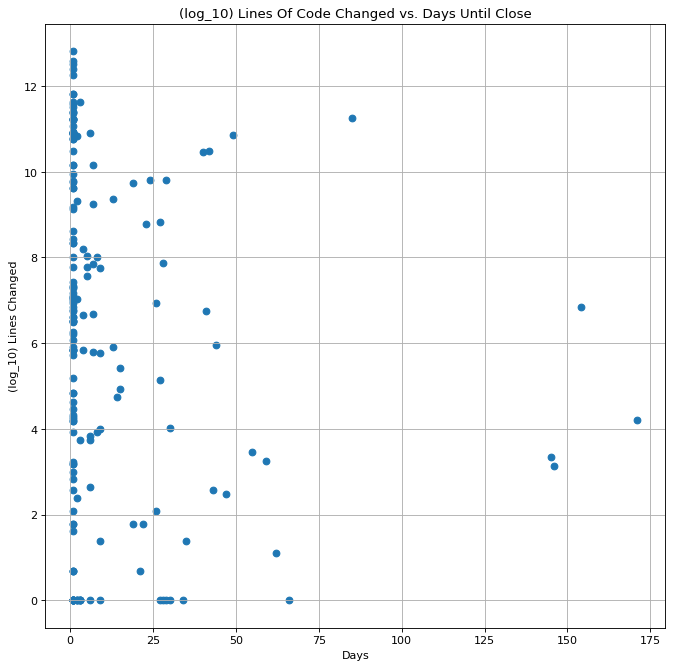

In [6]:
# map the total number of lines changed per PR
df_pr_closed_fc = df_pr_closed.assign(sumChanges = df_pr_closed['pr_id'].map(df_pr_closed.groupby('pr_id')['total_changes'].sum()))

# drop any extra columns so we just see the PR, the days required to merge, and the number of changes made across all files.
df_pr_closed_fc = df_pr_closed_fc.drop(['file_id', 'additions', 'deletions', 'total_changes', 'created', 'merged', 'closed'], axis=1).drop_duplicates('pr_id')

# plot
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_pr_closed_fc['close_window'], np.log(df_pr_closed_fc['sumChanges']))
plt.grid(True)
plt.title("(log_10) Lines Of Code Changed vs. Days Until Close")
plt.xlabel("Days")
plt.ylabel("(log_10) Lines Changed")
plt.show()

In the above graph we can see that there is little correlation between the amount of changes in a PR and the amount of time it takes for that PR to be closed.
This is very interesting behavior- one might intuit that small PR's would be spurriously closed often for not meeting community guidelines, for one example. 
It seems that instead, large PRs are the most often closed.

## Which PRs are still open and how long have they been open?

Those PRs with no 'merged' or 'closed' date are still open as of this analysis. Therefore they currently exist in the 
limbo between "going to be merged" and "going to be closed."

In [7]:
"""
These are the PRs that have yet to be merged or closed (are still open).
"""
df_pr_open = df_pr_files[df_pr_files['merged'].isna() & df_pr_files['closed'].isna()]
df_pr_open['open_window'] = datetime.now() - df_pr_open['created']
df_pr_open['open_window'] = df_pr_open['open_window'].apply(lambda d: d.days + 1)
df_pr_open.head()

,pr_id,file_id,additions,deletions,total_changes,created,merged,closed,open_window
32121,294093,1155220,376,0,376,2021-08-18 13:32:39,NaT,NaT,71
32122,294093,1155217,240,0,240,2021-08-18 13:32:39,NaT,NaT,71
32123,294093,1155218,7,0,7,2021-08-18 13:32:39,NaT,NaT,71
32124,294093,1155219,182,0,182,2021-08-18 13:32:39,NaT,NaT,71
32125,294093,1155221,4,23,27,2021-08-18 13:32:39,NaT,NaT,71


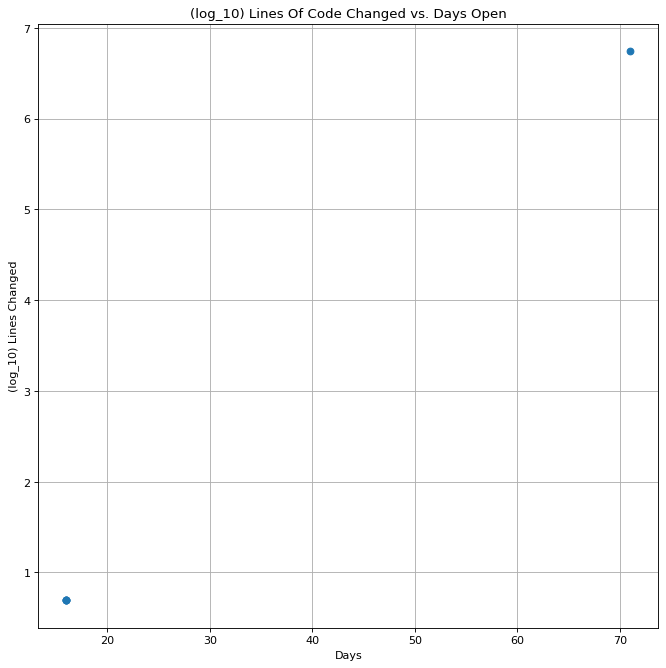

In [8]:
# map the total number of lines changed per PR
df_pr_open_fc = df_pr_open.assign(sumChanges = df_pr_open['pr_id'].map(df_pr_open.groupby('pr_id')['total_changes'].sum()))

# drop any extra columns so we just see the PR, the days required to merge, and the number of changes made across all files.
df_pr_open_fc = df_pr_open_fc.drop(['file_id', 'additions', 'deletions', 'total_changes', 'created', 'merged', 'closed'], axis=1).drop_duplicates('pr_id')

# plot
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_pr_open_fc['open_window'], np.log(df_pr_open_fc['sumChanges']))
plt.grid(True)
plt.title("(log_10) Lines Of Code Changed vs. Days Open")
plt.xlabel("Days")
plt.ylabel("(log_10) Lines Changed")
plt.show()

There does not appear to be any visual correlation between the number of days that a PR has remained open and the size of that PR, besides the greater mass of the PRs being more concentrated to smaller change-volumes.

## Which PRs have been merged and closed?

Those PRs that have been 'closed' and 'merged' are the successful PRs. They have become a part of the code base.

In [9]:
"""
These are the PRs that have been merged and closed.
"""
df_pr_merged = df_pr_files[df_pr_files['merged'].notna()]
df_pr_merged['merge_window'] = df_pr_merged['merged'] - df_pr_merged['created']
df_pr_merged['merge_window'] = df_pr_merged['merge_window'].apply(lambda d: d.days + 1)
df_pr_merged.head(5)

,pr_id,file_id,additions,deletions,total_changes,created,merged,closed,merge_window
0,293071,1123096,86,3,89,2017-01-23 18:50:08,2017-01-23 20:49:42,2017-01-23 20:49:42,1
1,293072,1123097,2,0,2,2017-01-31 17:08:16,2017-01-31 20:09:52,2017-01-31 20:09:52,1
2,293073,1123099,5,1,6,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19,1
3,293073,1123098,2,0,2,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19,1
10,293075,1123106,2,0,2,2017-02-01 20:41:17,2017-02-02 16:51:16,2017-02-02 16:51:16,1


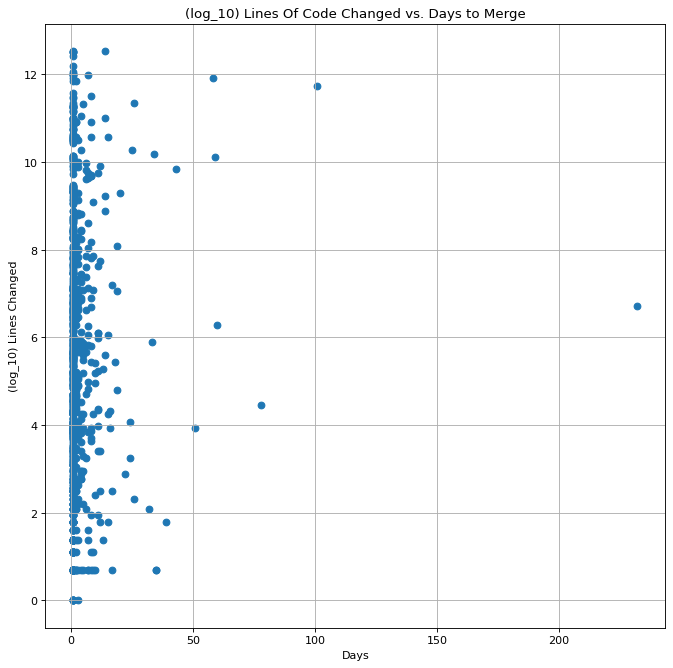

In [10]:
# map the total number of lines changed per PR
df_pr_merged_fc = df_pr_merged.assign(sumChanges = df_pr_merged['pr_id'].map(df_pr_merged.groupby('pr_id')['total_changes'].sum()))

# drop any extra columns so we just see the PR, the days required to merge, and the number of changes made across all files.
df_pr_merged_fc = df_pr_merged_fc.drop(['file_id', 'additions', 'deletions', 'total_changes', 'created', 'merged', 'closed'], axis=1).drop_duplicates('pr_id')

# plot
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_pr_merged_fc['merge_window'], np.log(df_pr_merged_fc['sumChanges']))
plt.grid(True)
plt.title("(log_10) Lines Of Code Changed vs. Days to Merge")
plt.xlabel("Days")
plt.ylabel("(log_10) Lines Changed")
plt.show()

Again, there appears to be very minimal correspondence between the size of the PR and its time-to-merge. Most PRs have <20 open-timespans irrespective of their size (from visual inspection).

## Does # of lines changed correlate visually with time-to-merge (and/or) merge-status?

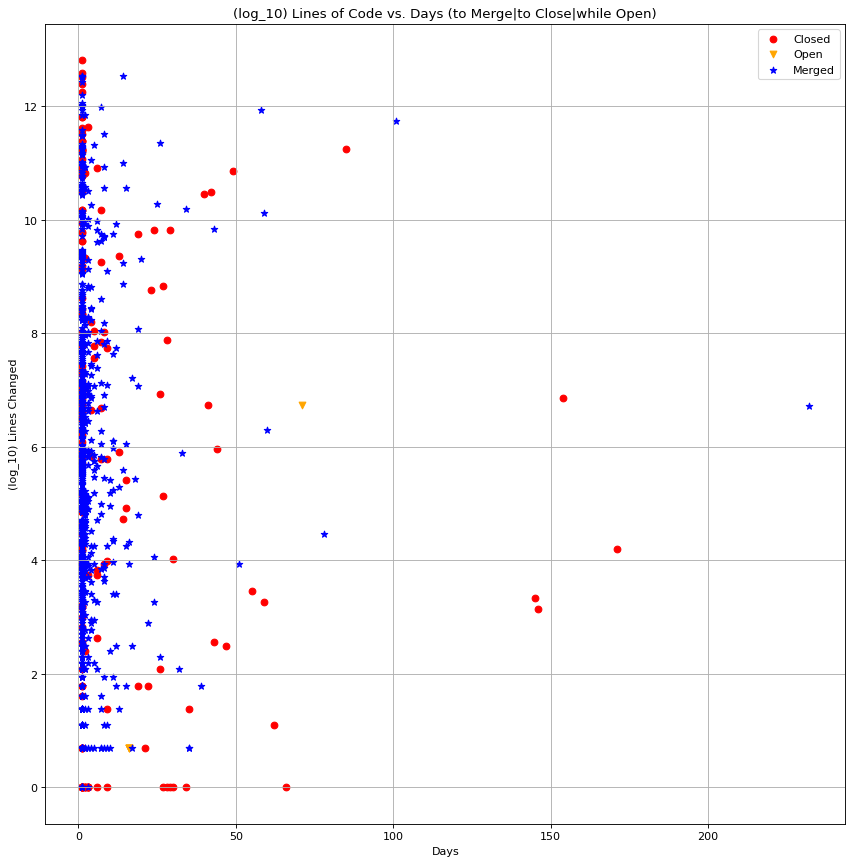

In [11]:
fig = plt.figure( figsize=(10,10), dpi=80 )
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Days")
ax.set_ylabel("(log_10) Lines Changed")
ax.set_title("(log_10) Lines of Code vs. Days (to Merge|to Close|while Open)")
ax.grid(True)
ax.scatter( df_pr_closed_fc['close_window'], np.log(df_pr_closed_fc['sumChanges']), color='red', marker='o', label="Closed")
ax.scatter( df_pr_open_fc['open_window'], np.log(df_pr_open_fc['sumChanges']), color='orange', marker='v', label="Open")
ax.scatter( df_pr_merged_fc['merge_window'], np.log(df_pr_merged_fc['sumChanges']), color='blue', marker='*', label="Merged")
ax.legend(["Closed", "Open", "Merged"])

Having plotted all three population of PR oon the same axes, the distributions of the data don't appear to be significantly different. Open PRs definitely dominate the right-most field of open-time, however, which could be a suggestion of some interesting project-specific phenomenon.

## Survival Analysis

We would like to be able to make some observations about the lifespan of PRs.

Specifically, we would like to model the experience of the contributors to a project probablistically. For example, we would like to know the probability that a user, in general, has a reasonably quick decision made about their contribution as a function of time. 

This is done with Survival Analysis. The below plots show the probability of a PR being merged or closed after some number of days.

In [13]:
from lifelines import KaplanMeierFitter

In [14]:
"""
    Need durations of all PR's as a column.
    This is just a total time bin up to today. 
    If a PR is still open we keep duration BUT we
    also park it as having been censored.
"""
closed_dur = df_pr_closed_fc['close_window'].to_numpy()
merged_dur = df_pr_merged_fc['merge_window'].to_numpy()
open_dur = df_pr_open_fc['open_window'].to_numpy()

total_durs = np.concatenate((np.concatenate((closed_dur, merged_dur)), open_dur))
print(total_durs)

censorship = np.ones( len(total_durs) )
censorship[len(closed_dur) + len(merged_dur): ] = 0

[ 1  6  1 ... 16 16 16]


Text(0, 0.5, 'Probability of Close')

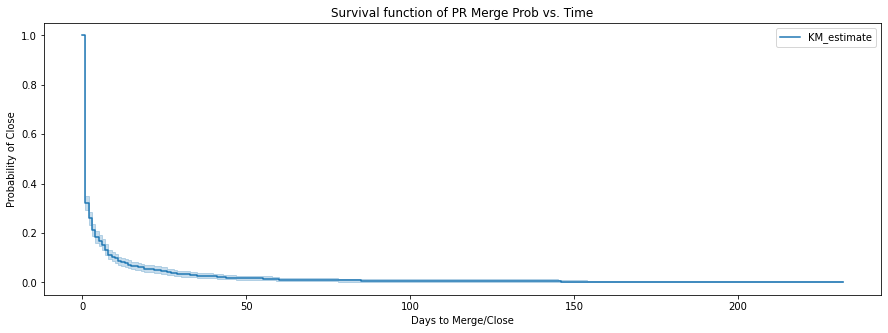

In [15]:
kmf = KaplanMeierFitter()
T = total_durs
C = censorship
kmf.fit(T, C)
kmf.plot()
plt.title('Survival function of PR Merge Prob vs. Time')
plt.xlabel("Days to Merge/Close")
plt.ylabel("Probability of Close")

By convention, we would like optimize the experience of roughly 80% of the contributions. This means that we would like to look at the above plot and observe the worst-case decision time for roughly 80% of PRs, which in this case is found at (~1 day, 0.2) as a coordinate. This is an exceptional result- likely being the case because the repo that we're working with is a smaller project with a core group of developers- but nonetheless it is an illustration of very good response-time to PRs.

One gap in this analysis is that the populations of 'closed' and 'merged' PRs are considered to be the same. However, this is obviously not true.

Text(0, 0.5, 'Probability of Close')

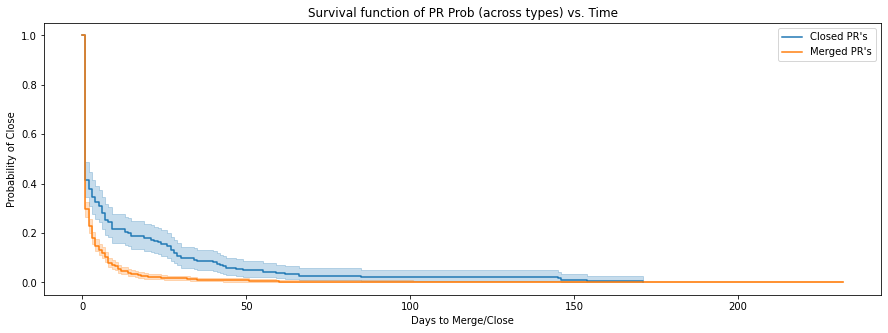

In [16]:
kmf2 = KaplanMeierFitter()
kmf2.fit(closed_dur, np.ones(len(closed_dur)), label="Closed PR's")
ax = kmf2.plot()
kmf2.fit(merged_dur, np.ones(len(merged_dur)), label="Merged PR's")
ax = kmf2.plot(ax=ax)
plt.title("Survival function of PR Prob (across types) vs. Time")
plt.xlabel("Days to Merge/Close")
plt.ylabel("Probability of Close")

This is a very informative visualization. It demonstrates some different behavior of the project with respect to the two different prior distributions of PRs- those that will be closed, and those that will be merged.

PRs that will be closed have a less aggressive decision-timeframe whereas those that are merged have a similarly rapid respone as the previous visualization demonstrates.

This visualization could be informative to projects, capturing a need of maintainers to make quicker decisions about PRs that they would like to close, or encouraging them to take more time to decide whether a PR should indeed be merged. 